In [2]:
import os
import time

import anndata as ad
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix, csr_matrix, vstack
from sklearn.metrics import pairwise_distances
from scipy.stats import ks_2samp

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import sys
sys.path.append('/weka/blake/packages/ecole/tissue-dynamics/scripts')
from generate_neighborhood_embeddings import compute_counts

/share/blake/anaconda3/envs/py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def load_proc_data():
    load_base = '/mnt/hsKidAt/blake_LTS/Atlas_V2/spatial/slide-seq/anndata/'
    h5ad_files = os.listdir(os.path.join(load_base))
    h5ad_files = [x for x in h5ad_files if x.split('.')[-1] == 'h5ad']
    df_list = []
    fields = ['cell_ID', 'v2.subclass.l1', 'v2.subclass.sp', 'v2.structure', 'condition', 'region_level1', 'region_level2', 'v2.state.l1', 'v2.state.l2', 'library', 'x', 'y', 'nCount_Spatial', 'nFeature_Spatial']
    # nFeature_Spatial - number of unique genes
    # nCount_Spatial - number of detected molecules
    meta = {cur_field: [] for cur_field in fields}
    for i in range(len(h5ad_files)):
        cur_ad = ad.read_h5ad(os.path.join(load_base, h5ad_files[i]), 'r')
        cur_df = cur_ad.uns['spatial'].reset_index(names=['cell_ID']).merge(right=cur_ad.obs, left_on='cell_ID', right_on='cell_ID')
        cur_df = cur_df[fields]
        df_list.append(cur_df)
    df = pd.concat(df_list, axis=0, ignore_index=True)
    return df
#t = time.time()
df_proc = load_proc_data()
#print(f'data loading complete in {(time.time()-t)/60.0:.1f} min.')

In [4]:
def build_sparse_matrix(class_counts, num_cols=None):
    # class_counts is a list of 2-tuples, each being (labels, counts)
    data = []
    rows = []
    cols = []
    for i in range(len(class_counts)):
        labels, counts = class_counts[i]
        data.extend(counts)
        rows.extend([i]*len(counts))
        cols.extend(labels)
    if num_cols is not None:
        sp = coo_matrix((data, (rows, cols)), shape=(np.max(rows)+1, num_cols))
    else:
        sp = coo_matrix((data, (rows, cols)), shape=(np.max(rows)+1, np.max(cols)+1))
    sp = csr_matrix(sp)
    return sp

t = time.time()
num_nb = 100 # 15, 100
nb_counts = []
nb_counts_cell_id = []
library_list = sorted(df_proc['library'].unique())
cell_state_identifier = 'v2.subclass.sp'
cell_states = sorted(df_proc[cell_state_identifier].unique())
cell_state_name_to_id = {cell_states[i]: i for i in range(len(cell_states))}
df_proc['cell_state'] = [cell_state_name_to_id[cur_name] for cur_name in df_proc[cell_state_identifier].to_numpy()]
num_cell_states = len(df_proc[cell_state_identifier].unique())
for i in range(len(library_list)):
    # find neighbors:
    cur_df_proc = df_proc[df_proc['library'] == library_list[i]]
    print(f'-> processing library {library_list[i]} with {cur_df_proc.shape[0]} beads')
    cur_coords = cur_df_proc[['x', 'y']].to_numpy()
    cur_labels = cur_df_proc['cell_state'].to_numpy()
    cur_cell_ID = cur_df_proc['cell_ID'].to_numpy()
    cur_nb_counts = build_sparse_matrix(compute_counts(cur_coords, cur_labels, cur_coords, num_nb, skip_first=True), num_cols=num_cell_states)
    nb_counts.append(cur_nb_counts)
    nb_counts_cell_id.append(cur_cell_ID)
global_nb_counts = vstack(nb_counts, format='csr')
nb_counts_cell_id = np.concatenate(nb_counts_cell_id, axis=0)
print(f'neighborhood counts\t\t\t{np.around((time.time()-t)/60.0,1)} minutes')

-> processing library Puck_200903_01 with 17011 beads
-> processing library Puck_200903_02 with 15925 beads
-> processing library Puck_200903_03 with 18630 beads
-> processing library Puck_200903_05 with 19774 beads
-> processing library Puck_200903_06 with 25138 beads
-> processing library Puck_200903_07 with 19943 beads
-> processing library Puck_200903_25 with 22080 beads
-> processing library Puck_200903_26 with 18719 beads
-> processing library Puck_200906_10 with 21548 beads
-> processing library Puck_200906_18 with 19978 beads
-> processing library Puck_210113_21 with 27030 beads
-> processing library Puck_210113_22 with 18238 beads
-> processing library Puck_210113_23 with 18410 beads
-> processing library Puck_210113_24 with 10330 beads
-> processing library Puck_210113_25 with 7037 beads
-> processing library Puck_210113_26 with 22189 beads
-> processing library Puck_210113_27 with 20157 beads
-> processing library Puck_210113_28 with 22466 beads
-> processing library Puck_21

In [5]:
# sort rows of global_nb_counts to match df_proc:
df_proc_cell_id = df_proc['cell_ID'].to_numpy().tolist()
cell_id_to_index_df_proc = {df_proc_cell_id[i]: i for i in range(len(df_proc_cell_id))}
idx_reorder = np.array([cell_id_to_index_df_proc[cur_id] for cur_id in nb_counts_cell_id])
global_nb_counts = global_nb_counts[idx_reorder, :]

In [6]:
print(sorted(df_proc['v2.subclass.sp'].unique()))

['ATL', 'B', 'C-FIB', 'C-FIB-OSMRhi', 'C-FIB-OSMRlo', 'C-FIB-Path', 'C-MYOF', 'C-TAL', 'C/M-FIB', 'CD8+ TEM/TEMRA', 'CD8+ TEM/TRM', 'CNT', 'DCT', 'DTL1', 'DTL2', 'DTL3', 'EC-AA', 'EC-AVR', 'EC-DVR', 'EC-EA', 'EC-GC', 'EC-LYM', 'EC-PCV', 'EC-PTC', 'EC-V', 'ERY', 'IC-A', 'IC-B', 'ILC3', 'IM-pvMYOF', 'IMCD', 'M-FIB', 'M-TAL', 'MAIT', 'MAST', 'MC', 'MD', 'MON', 'N', 'NK', 'PC', 'PEC', 'PL', 'POD', 'PT-S1/2', 'PT-S3', 'REN', 'T', 'T-REG', 'VSMC', 'VSMC/P', 'aCNT', 'aDCT', 'aPT', 'aTAL1', 'aTAL2', 'angEC-PTC', 'cDC1', 'cDC2', 'frPT', 'frTAL', 'infEC-AVR', 'infEC-PTC', 'mDC', 'moFAM', 'moMAC-C3+', 'moMAC-INF', 'ncMON', 'pDC', 'pvFIB', 'pvFIB-PI16+', 'pvFIB-RSPO3+', 'pvMYOF', 'resMAC-HLAIIhi', 'resMAC-LYVE1+', 'tPC-IC']


In [7]:
target_cells = ['pvFIB-RSPO3+','pvFIB-PI16+','pvFIB','pvMYOF','C-FIB-OSMRhi', 'C-MYOF'] # perivascular and inflammatory interstitial fibroblast types
# target_cells = ['C-FIB', 'C-FIB-Path', 'C-FIB-OSMRhi', 'C-MYOF'] # interstitial fibroblast types
# target_cells = ['B', 'PL', 'T', 'T-REG', 'T-CYT', 'tdT-CYT', 'NK'] # lymphoid types
#target_cells = ['MAST', 'MAC-LYVE1', 'MAC-MHC', 'MAC-INF', 'LAM', 'MDC', 'cDC2', 'ncMON', 'MON', 'mDC', 'cDC1', 'pDC', 'N'] # myeloid types
region = 'Cortex' # Cortex, Outer Medulla
all_cells = sorted(df_proc['v2.subclass.sp'].unique())

min_cells = 10
p_list = []
stat_list = []
sign_list = []
# valid_list = []
for cur_cell in target_cells:
    

    a = global_nb_counts[(df_proc['v2.subclass.sp'] == cur_cell) & (df_proc['region_level2'] == region) & (df_proc['condition'] == 'Healthy Reference Tissue'), :].toarray().squeeze()
    b = global_nb_counts[(df_proc['v2.subclass.sp'] == cur_cell) & (df_proc['region_level2'] == region) & (df_proc['condition'].isin(['Chronic Kidney Disease', 'Diabetic Kidney Disease','Acute Kidney Injury'])), :].toarray().squeeze()

    # for each cell type, want to determine if valid for analysis
    # valid_list.append()
    # a.sum(axis=0) # number of times each cell type is a neighbor

    # valid_cell_types.append((a.shape[0] > min_cells) & (b.shape[0] > min_cells))
    
    a = a / np.sum(a, axis=1, keepdims=True)
    b = b / np.sum(b, axis=1, keepdims=True)

    ks = ks_2samp(a, b, axis=0)
    p_list.append(ks.pvalue)
    # p value would also capture effect of N...
    stat_list.append(ks.statistic)
    sign_list.append(ks.statistic_sign)

A note about interpreting the test statistic sign: If the sign is positive, it means that the CDF is higher for the first dataset than the second at the test statistic location. This means that the first dataset has a distribution that is left-shifted (i.e. smaller) relative to the second distribution. In this case, a positive sign corresponds to depletion in healthy / enrichment in unhealthy. 

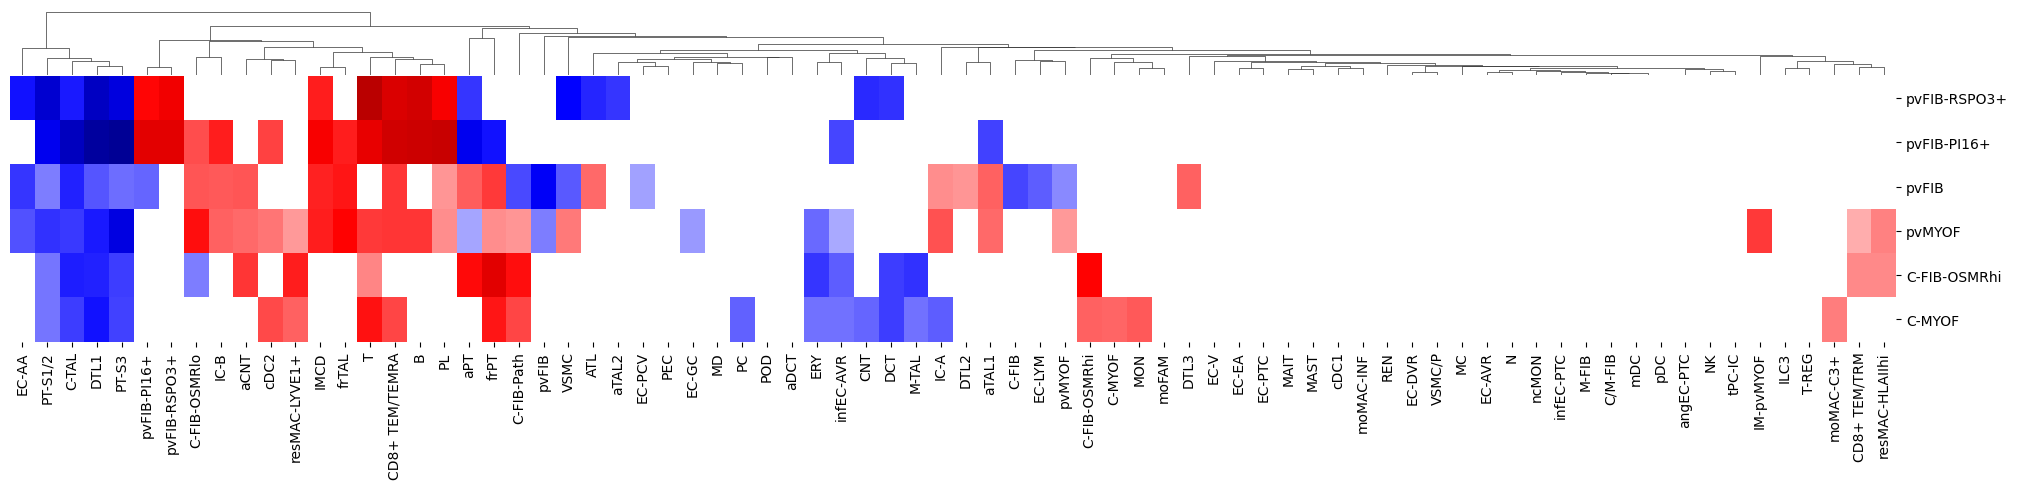

In [8]:
p_thresh = 1e-2 # mask out cells corresponding to p-values larger than p_thresh
ax = sns.clustermap(data=np.array(sign_list)*np.array(stat_list), row_cluster=False, col_cluster=True, figsize=(25, 5), xticklabels=cell_states, yticklabels=target_cells, cmap='seismic', vmin=-1, vmax=1, mask=np.array(p_list) >= p_thresh)
ax.tick_params(axis='x', which='major', labelsize=10)
ax.cax.set_visible(False)
ax.ax_row_dendrogram.set_visible(False)

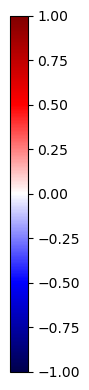

In [9]:
fig, ax = plt.subplots(figsize=(1, 4))
cmap = mpl.colormaps['seismic']
norm = mpl.colors.Normalize(vmin=-1, vmax=1)  # or vmin, vmax
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm, cmap), ax)
plt.tight_layout()
plt.show()

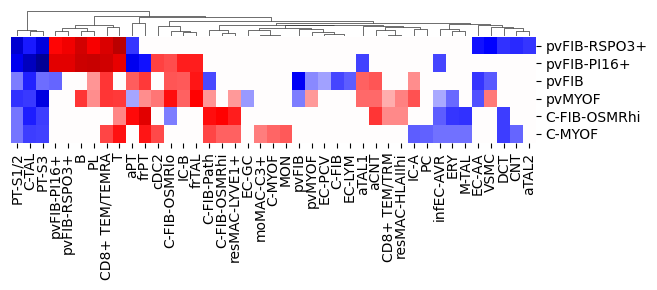

In [10]:
mask = np.array(p_list) < 1e-2

# Use this mask to filter the data arrays
filtered_data = np.array(sign_list) * np.array(stat_list) * mask

# Identify columns that have at least one significant value
valid_columns = np.any(filtered_data, axis=0)

# Exclude specific columns by name, e.g., 'ATL' and 'IMCD'
exclude_columns = (np.array(cell_states) != 'ATL') & (np.array(cell_states) != 'IMCD') & (np.array(cell_states) != 'DTL1') & (np.array(cell_states) != 'DTL2') & (np.array(cell_states) != 'DTL3') & (np.array(cell_states) != 'IM-pvMYOF')

# Combine valid columns with exclusion of specific columns
final_columns = valid_columns & exclude_columns

# Filter the data to include only these columns
final_data = filtered_data[:, final_columns]

# Update xticklabels to correspond to the filtered columns
updated_xticklabels = np.array(cell_states)[final_columns]

# Create the clustermap with the filtered data
ax = sns.clustermap(data=final_data, row_cluster=False, col_cluster=True, figsize=(8, 3), xticklabels=updated_xticklabels, yticklabels=target_cells, cmap='seismic', vmin=-1, vmax=1)
ax.tick_params(axis='x', which='major', labelsize=10)
ax.cax.set_visible(False)
ax.ax_row_dendrogram.set_visible(False)

# Save the figure as a PDF file
ax.savefig('/home/blake/Projects/Human_Kidney/Atlas_V2/slide-seq/neighborhoods/pvFIB-intFIB_Cortex_Neighbors_p01_heatmap.pdf')

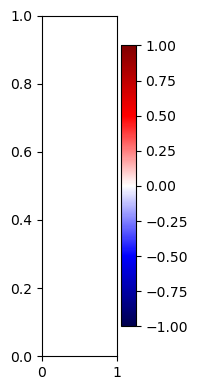

In [11]:
fig, ax = plt.subplots(figsize=(2, 4))
cmap = mpl.colormaps['seismic']
norm = mpl.colors.Normalize(vmin=-1, vmax=1)  # or vmin, vmax
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm, cmap), ax=ax)
plt.tight_layout()
fig.savefig('/home/blake/Projects/Human_Kidney/Atlas_V2/slide-seq/neighborhoods/pvFIB-intFIB_Cortex_Neighbors_p01_heatmap_scalebar.pdf')  # Save the figure as a PDF file

In [12]:
p_thresh = 1e-2

data = np.array(sign_list) * np.array(stat_list)
data_frame = pd.DataFrame(data, columns=cell_states, index=target_cells)

data_frame

# Write the DataFrame to a CSV file
data_frame.to_csv('/home/blake/Projects/Human_Kidney/Atlas_V2/slide-seq/neighborhoods/pvFIB-intFIB_Cortex_Neighbors_p01_heatmap_data.csv')

In [13]:
data = np.array(p_list) 
data_frame = pd.DataFrame(data, columns=cell_states, index=target_cells)

data_frame

# Write the DataFrame to a CSV file
data_frame.to_csv('/home/blake/Projects/Human_Kidney/Atlas_V2/slide-seq/neighborhoods/pvFIB-intFIB_Cortex_Neighbors_p01_heatmap_pVals.csv')